# California House prices

## Load data and initial exploration

In [1]:
import pandas as pd
HOUSES_CSV_PATH = ('/home/diego/Documents/Books/Hands_on_Machine_Learning_with_Scikit_Learn/'
                   'handson-ml/datasets/housing/housing.csv')
housing = pd.read_csv(HOUSES_CSV_PATH)
print('Shape: ', housing.shape)
target = 'median_house_value'
print('Target: ', target)
housing.head(10)

Shape:  (20640, 10)
Target:  median_house_value


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## Stratified train-test split 

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


def stratified_split(df, col):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(df, df[col]):
        strat_train = df.loc[train_index]
        strat_test = df.loc[test_index]
    return strat_train, strat_test

def split_and_compare(housing):
    # To reduce sampling bias, it is desirable to make a stratified sample of train-test
    # As median income is a very important feature in the dataset, it will be used for the stratified split
    # housing["median_income"].hist()
    housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                   labels=[1, 2, 3, 4, 5])
    # housing["income_cat"].value_counts() / len(housing)
    # housing["income_cat"].hist()

    def income_cat_proportions(df, col):
        return df[col].value_counts() / len(df)

    # Compare the two train-test splits:
    train, test = train_test_split(housing, test_size=0.2, random_state=42)
    strat_train, strat_test = stratified_split(housing, 'income_cat')
    compare_props = pd.DataFrame({"income_cat": housing['income_cat'].value_counts().index,
                                  "Overall": income_cat_proportions(housing, 'income_cat'),
                                  "Stratified": income_cat_proportions(strat_test, 'income_cat'),
                                  "Random": income_cat_proportions(test, 'income_cat')}
                                 ).sort_index()
    compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
    compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
    print('Bias error comparison, normal split vs. stratified split:\n', compare_props)
    del housing['income_cat'], strat_train['income_cat'], strat_test['income_cat'],
    del train['income_cat'], test['income_cat']
    return strat_train, strat_test



train_raw, test_raw = split_and_compare(housing)
print('\nTrain shape: ', train_raw.shape, '\nTest shape: ', test_raw.shape)

Bias error comparison, normal split vs. stratified split:
   income_cat   Overall  Stratified    Random  Rand. %error  Strat. %error
1          1  0.039826    0.039729  0.040213      0.973236      -0.243309
2          2  0.318847    0.318798  0.324370      1.732260      -0.015195
3          3  0.350581    0.350533  0.358527      2.266446      -0.013820
4          4  0.176308    0.176357  0.167393     -5.056334       0.027480
5          5  0.114438    0.114583  0.109496     -4.318374       0.127011

Train shape:  (16512, 10) 
Test shape:  (4128, 10)


## Data exploration and feature engineering

### Pair plots to identify the most important features
This actually loads a custom made pair plot library.
Source: https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another

In [4]:
%cd /home/diego/Documents/Books/Hands_on_Machine_Learning_with_Scikit_Learn/handson-ml/Diego
from PairPlot import pair_plot, joint_plot  # custom-made pairs plot library

/home/diego/Documents/Books/Hands_on_Machine_Learning_with_Scikit_Learn/handson-ml/Diego


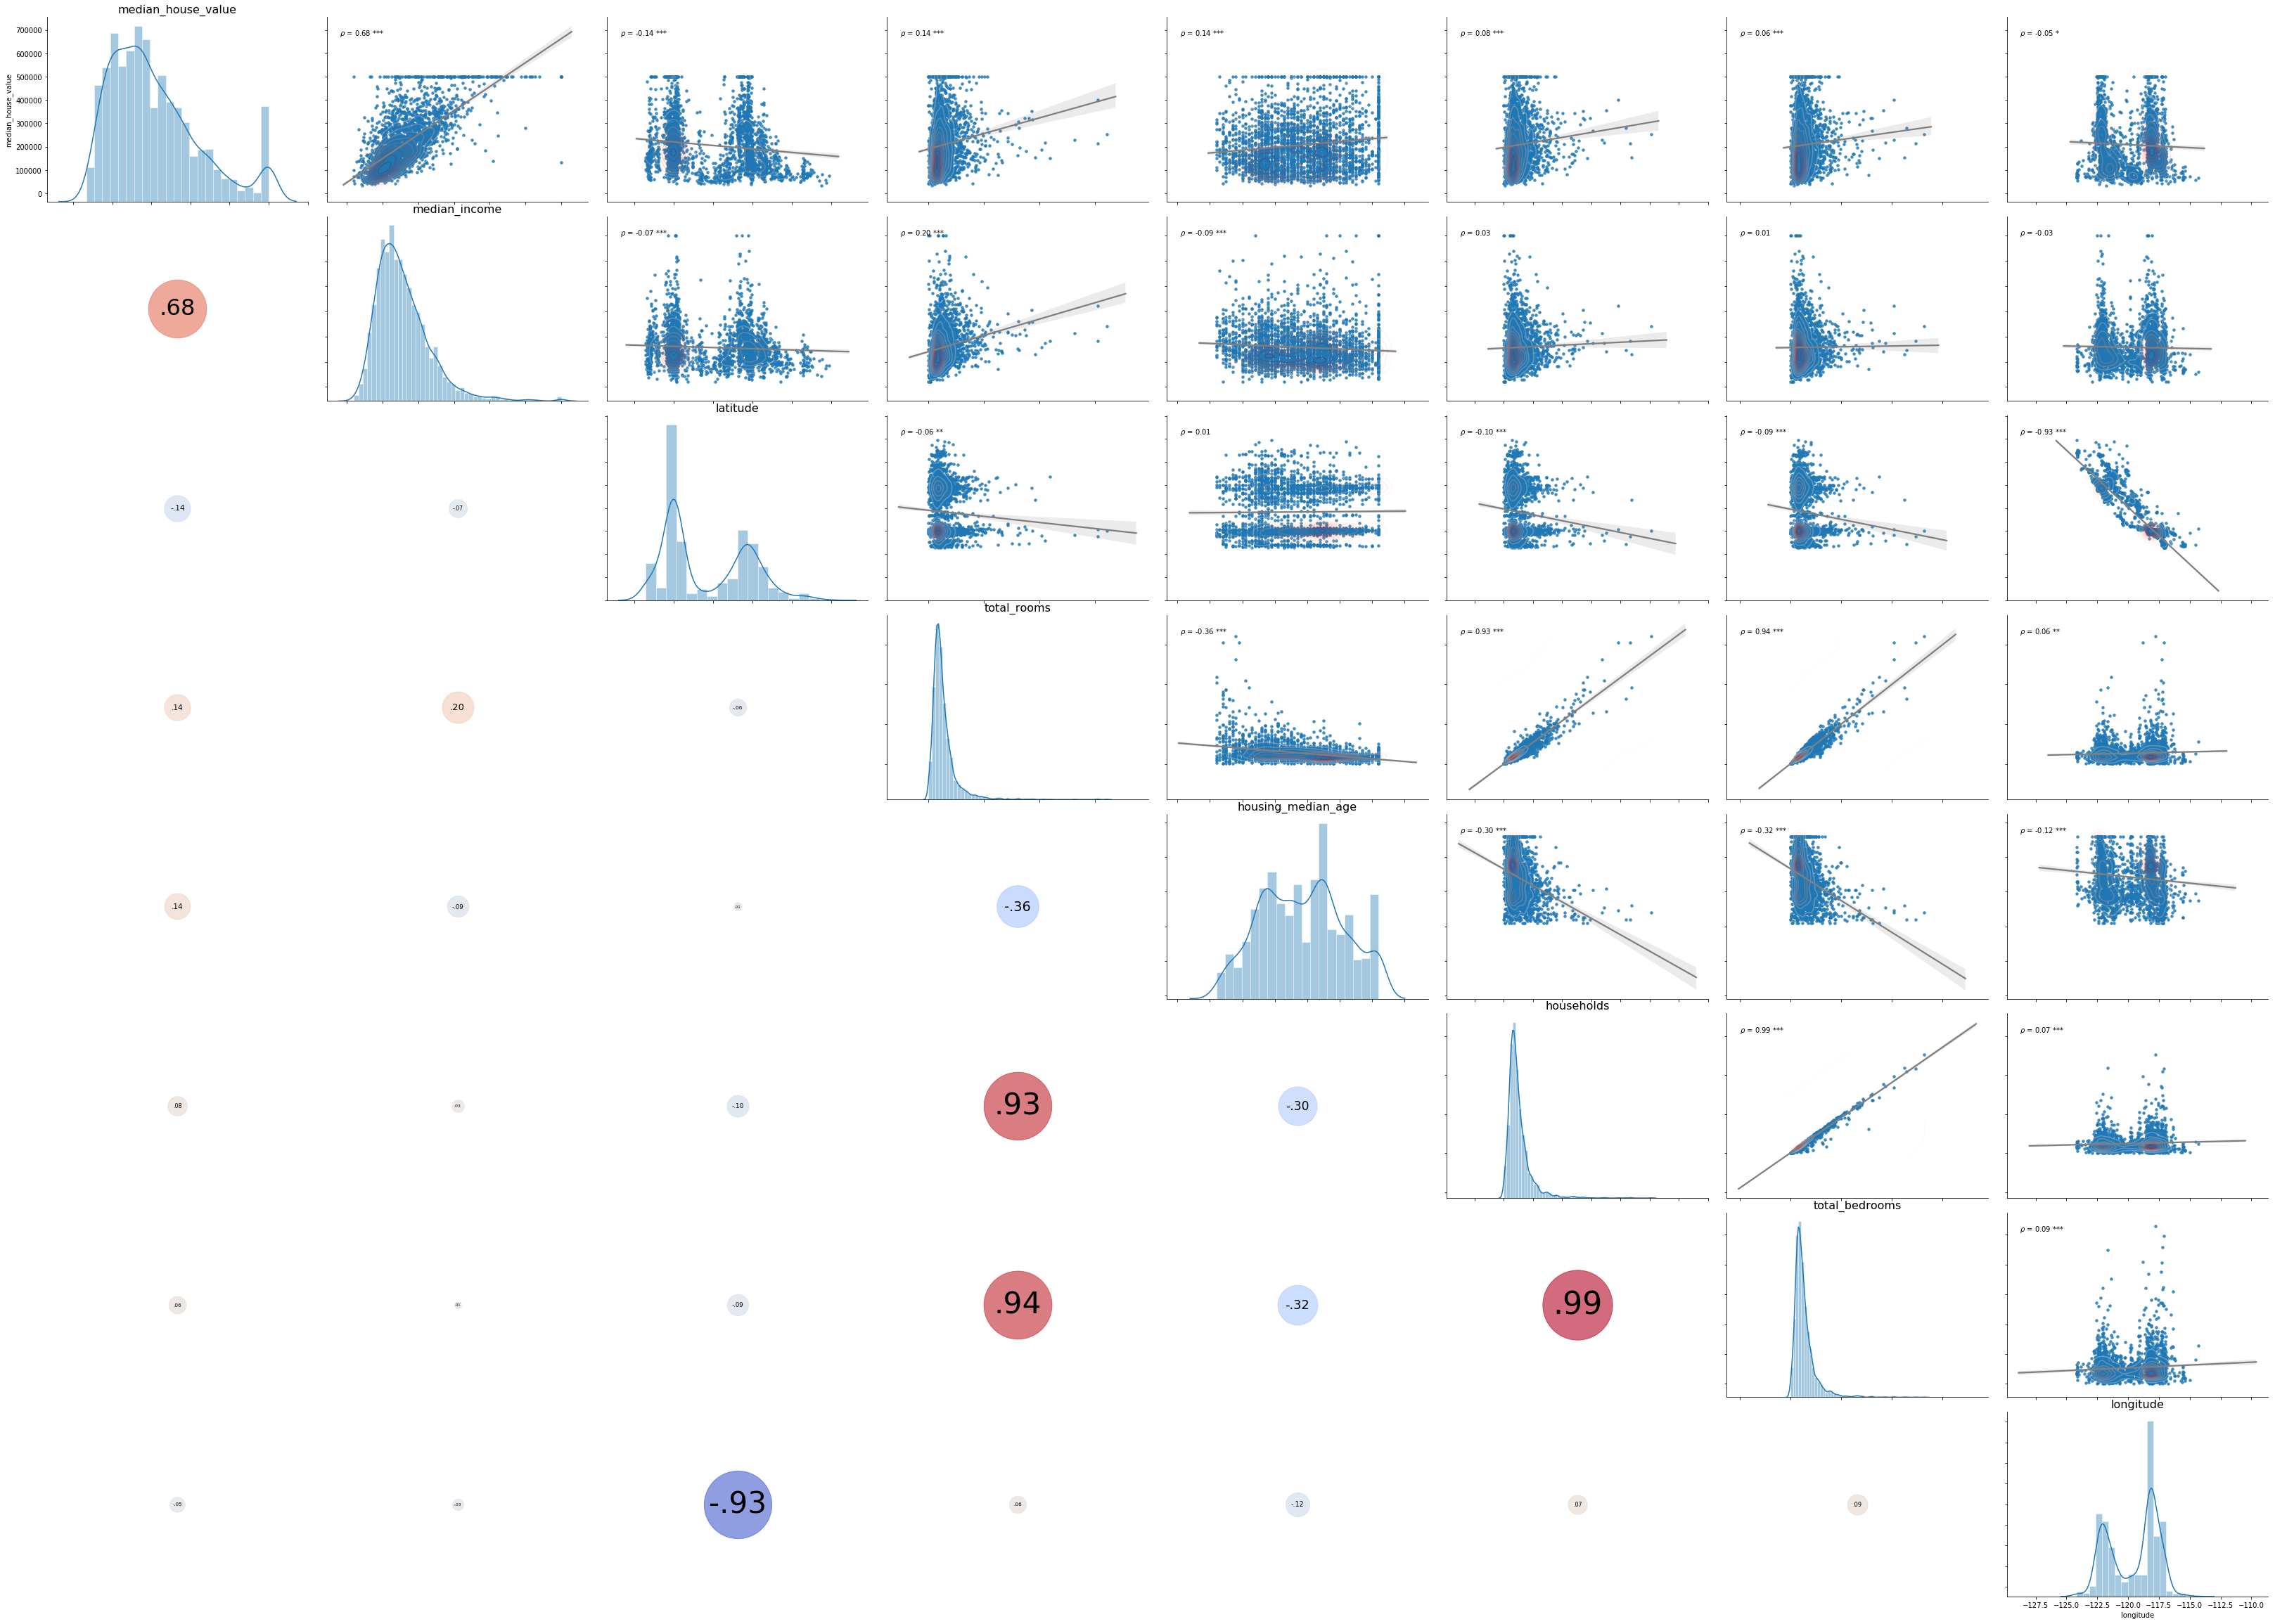

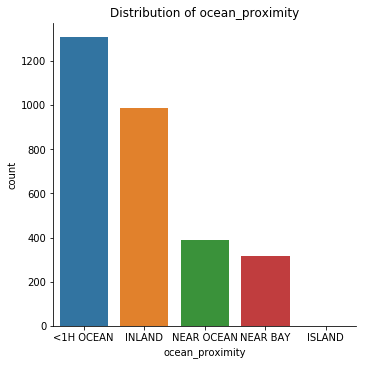

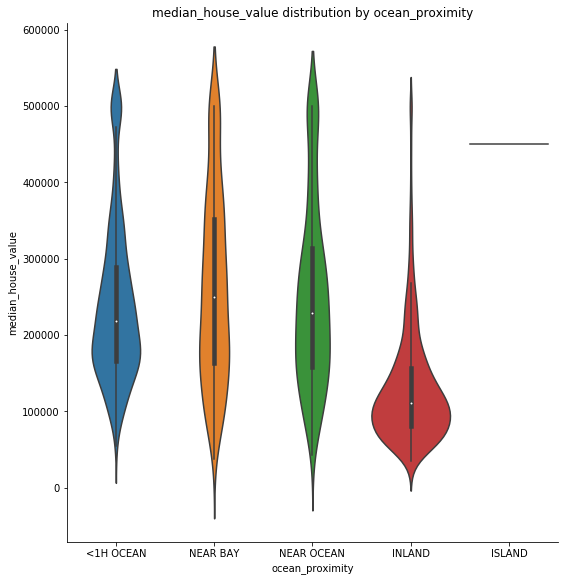

In [4]:
pair_plot(housing, sample=3000, main_col='median_house_value', num_cols=8)

Some observations:
  - The most correlated variables with target are 'median_income', 'total_beds' and latitude
  - There seems to be two modes in the 'latitude' histogram plot => it could be nice to try a Gaussian RBF transformation
  - Prices are lower if houses are not close to the ocean (inland)

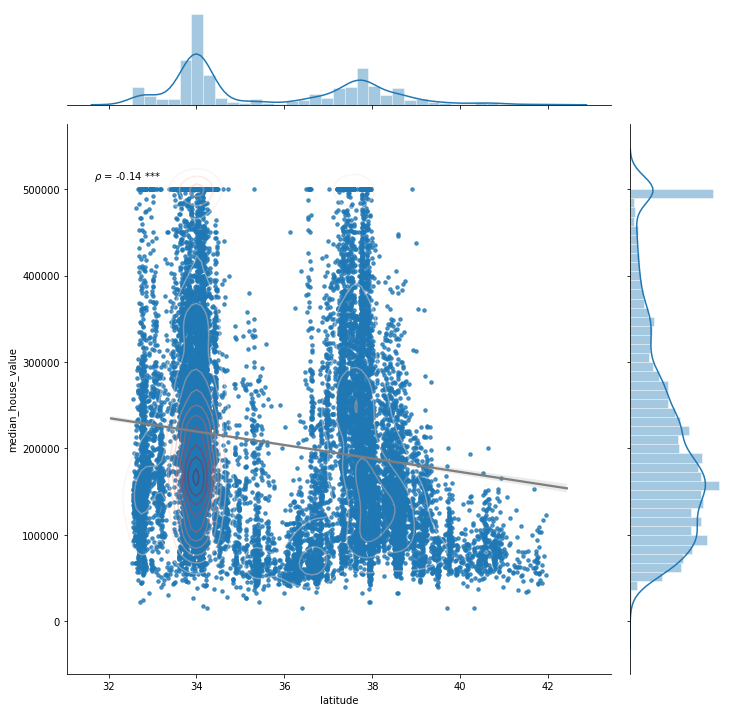

In [5]:
joint_plot(housing, x='latitude', y='median_house_value', height=10)

 Gaussian RBF: 
 $\phi(x, l) = exp(-\gamma\left\Vert x - l\right\Vert^2)$
 
 - Use as landmarks for the Guassian RBF: (34, 38)

### Separate X and y using target: median_house_value

In [3]:
target = 'median_house_value'
X_train_raw, y_train_raw = train_raw.drop(target, axis=1), train_raw[target]
X_test_raw, y_test_raw = test_raw.drop(target, axis=1), test_raw[target]
print('X_train_raw shape: ', X_train_raw.shape)
print('X_test_raw shape: ', X_test_raw.shape)

X_train_raw shape:  (16512, 9)
X_test_raw shape:  (4128, 9)


### Feature engineering: creating new variables

Define a Transformer class used to create new features:

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin  # for creating custom transformers


class ExtendFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, gamma = 3):   # no *args or **kargs
        self.gamma = gamma
        pass
    
    def transform(self, X, y=None):
        X = X.copy()
        # Implement Gaussian RBF (test)
        X['latitude_l1'] = np.exp(-self.gamma * (X['latitude'] - 34) ** 2)
        X['latitude_l2'] = np.exp(-self.gamma * (X['latitude'] - 38) ** 2)
        # Add other variables
        X['rooms_per_house'] = X['total_rooms'] / X['households']
        X['population_per_house'] = X['population'] / X['households']
        X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
        # Save column names
        self.columns = list(X.columns)
        return X
    
    
    def fit(self, X, y=None):
        return self          # do nothing
    
    def get_feature_names(self):
        return self.columns

# Pipeline construction with sklearn-pandas: initial linear regression model

In [5]:
# Select columns by numeric or categorical type
num_cols = X_train_raw.select_dtypes(['number']).columns
cat_cols = X_train_raw.select_dtypes(exclude=['number']).columns
print(f'Numeric features: {", ".join(num_cols)}')
print(f'\nCategorical features: {", ".join(cat_cols)}')

Numeric features: longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income

Categorical features: ocean_proximity


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer

# Define numeric pipeline
num_preprocess = Pipeline(steps=[
    ('feature_engineering', ExtendFeatures()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define categorical pipeline
cat_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   # it also works for categoricals
    ('encoder', OneHotEncoder())
])

In [7]:
from sklearn.compose import ColumnTransformer

preprocessing_pipe = ColumnTransformer(transformers=[
    ('numeric', num_preprocess, num_cols),
    ('categorical', cat_preprocess, cat_cols)
])

In [8]:
X = preprocessing_pipe.fit_transform(X_train_raw)

In [9]:
X.shape

(16512, 18)

In [10]:
import re
from sklearn_pandas import DataFrameMapper


def get_column_names_from_ColumnTransformer(column_transformer, verbose=True):    
    col_names = []
    transformers = column_transformer.named_transformers_   # returns a dict
    for key, transformer in transformers.items():
        print(f'\nAnalyzing transformer: \'{key}\'')
        if isinstance(transformer, Pipeline):
            steps = transformer.steps
            for step_name, step in steps:
                print(f' Step {step_name} of transformer {key}')
                if isinstance(step, DataFrameMapper):
                    print('  DataFrameMapper')
                    col_names = step.transformed_names_.copy()   # careful, hard reset of names! WIP
                    print('  features: ', col_names)
                else:
                    try:
                        cols = step.get_feature_names()
                        col_names.extend(cols)
                        print('  features: ', cols)
                    except AttributeError:
                        pass
    # clean names
    col_names = [re.sub('[^(0-9_a-zA-Z)]', '', col) for col in col_names]
    return col_names
                
            

cols = get_column_names_from_ColumnTransformer(preprocessing_pipe)
print(cols, len(cols))


Analyzing transformer: 'numeric'
 Step feature_engineering of transformer numeric
  features:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'latitude_l1', 'latitude_l2', 'rooms_per_house', 'population_per_house', 'bedrooms_per_room']
 Step imputer of transformer numeric
 Step scaler of transformer numeric

Analyzing transformer: 'categorical'
 Step imputer of transformer categorical
 Step encoder of transformer categorical
  features:  ['x0_<1H OCEAN' 'x0_INLAND' 'x0_ISLAND' 'x0_NEAR BAY' 'x0_NEAR OCEAN']
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'latitude_l1', 'latitude_l2', 'rooms_per_house', 'population_per_house', 'bedrooms_per_room', 'x0_1HOCEAN', 'x0_INLAND', 'x0_ISLAND', 'x0_NEARBAY', 'x0_NEAROCEAN'] 18


In [12]:
X_df = pd.DataFrame(X, columns=cols)
X_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,latitude_l1,latitude_l2,rooms_per_house,population_per_house,bedrooms_per_room,x0_1HOCEAN,x0_INLAND,x0_ISLAND,x0_NEARBAY,x0_NEAROCEAN
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.906116,0.068217,-0.312055,-0.086499,0.193805,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,-0.906116,-0.394411,0.217683,-0.033534,-0.940745,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.882443,-0.595186,-0.465315,-0.092405,0.499160,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.906116,-0.594614,-0.079661,0.089736,-0.208675,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,0.983937,-0.595186,-0.357834,-0.004194,0.324937,1.0,0.0,0.0,0.0,0.0
5,-0.696456,0.945009,-0.370047,0.143693,0.131447,0.025285,0.194138,-0.176435,-0.906116,1.532696,-0.114867,-0.048003,-0.211891,0.0,1.0,0.0,0.0,0.0
6,0.537433,-0.748168,1.856709,-0.182253,-0.528198,-0.583328,-0.585720,2.366702,1.298393,-0.595186,1.003599,-0.027646,-1.240095,1.0,0.0,0.0,0.0,0.0
7,1.166867,-0.696718,-0.210993,-0.272040,-0.586617,-0.433639,-0.324880,1.115239,1.164415,-0.595186,0.000891,-0.051831,-1.212156,0.0,1.0,0.0,0.0,0.0
8,0.657325,-0.771554,1.459074,-0.354345,-0.167949,0.444770,-0.157197,-1.076906,1.308336,-0.595186,-0.452724,0.110319,0.639919,1.0,0.0,0.0,0.0,0.0
9,0.647334,-0.757522,0.027588,-0.985660,-0.742400,1.138535,-0.745417,-1.772116,1.306344,-0.595186,-1.174387,0.802788,4.060146,1.0,0.0,0.0,0.0,0.0


## Training a linear regression using these 18 features

In [12]:
import statsmodels.formula.api as smf

X_df_lm = X_df.copy()
X_df_lm['median_house_value'] = y_train_raw.values

formula = 'median_house_value ~ ' + ' + '.join(X_df.columns)
lm = smf.ols(formula=formula, data=X_df_lm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     1887.
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:58:40   Log-Likelihood:            -2.0702e+05
No. Observations:               16512   AIC:                         4.141e+05
Df Residuals:                   16494   BIC:                         4.142e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.006e+05   7971.833     25.166      0.000    1.85e+05    2.16e+05
longitude            -6.163e+04   2357.707    -26.140      0.000   -6.63e+04    -5.7e+04
latitude             -5.213e+04   2403.302    -21.690      0.000   -5.68e+04   -4.74e+04
housing_median_age    1.083e+04    627.753     17.247      0.000    9596.700    1.21e+04
total_rooms           9300.6042   2219.591      4.190      0.000    4949.966    1.37e+04
total_bedrooms       -2028.6842   3075.561     -0.660      0.510   -8057.116    3999.748
population           -4.761e+04   1351.136    -35.240      0.000   -5.03e+04    -4.5e+04
households            4.447e+04   3051.561     14.572      0.000    3.85e+04    5.04e+04
median_income         7.608e+04    787.846     96.572      0.000    7.45e+04    7.76e+04
latitude_l1           1.658e+04    873.797     18.977      0.000    1.49e+04    1.83e+04
latitude_l2            -59.5348    907.311     -0.066      0.948   -1837.963    1718.893
rooms_per_house       7427.1132    663.049     11.201      0.000    6127.465    8726.762
population_per_house  1128.8272    543.559      2.077      0.038      63.394    2194.260
bedrooms_per_room     1.512e+04    877.868     17.218      0.000    1.34e+04    1.68e+04
x0_1HOCEAN            1.218e+04   8015.774      1.519      0.129   -3534.509    2.79e+04
x0_INLAND            -1.573e+04   8115.050     -1.938      0.053   -3.16e+04     176.440
x0_ISLAND             1.552e+05   3.98e+04      3.901      0.000    7.72e+04    2.33e+05
x0_NEARBAY            1.806e+04   8176.280      2.209      0.027    2034.730    3.41e+04
x0_NEAROCEAN          3.094e+04   8075.425      3.832      0.000    1.51e+04    4.68e+04
==============================================================================
Omnibus:                     4505.195   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23218.929
Skew:                           1.223   Prob(JB):                         0.00
Kurtosis:                       8.270   Cond. No.                     2.12e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.46e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
from sklearn.metrics import mean_squared_error

X_test = preprocessing_pipe.transform(X_test_raw)
X_test_df = pd.DataFrame(X_test, columns=cols)
test_predictions = lm.predict(X_test_df)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw.values))
mape_test = np.mean(np.abs(y_test_raw.values - test_predictions) / y_test_raw.values) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  66166.40301502532
Test MAPE:  28.731225574796866


## Creating poly features for selected columns

In [127]:
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.preprocessing import PolynomialFeatures

cols_to_poly = ['median_income', 'rooms_per_house', 'population_per_house', 'longitude']

transformers = [{'class': PolynomialFeatures, 'degree': 5, 'include_bias': False}]
col_trans = gen_features([[col] for col in cols_to_poly], transformers)

poly_adder = DataFrameMapper(col_trans , df_out=True, default=None)

## creating new pipeline including poly features

In [128]:
# Define numeric pipeline
num_poly_preprocess = Pipeline(steps=[
    ('feature_engineering', ExtendFeatures()),
    ('poly_adder', poly_adder),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

poly_preprocessing_pipe = ColumnTransformer(transformers=[
    ('numeric', num_poly_preprocess, num_cols),
    ('categorical', cat_preprocess, cat_cols)
])

In [129]:
X = poly_preprocessing_pipe.fit_transform(X_train_raw)
print(X.shape)
X

(16512, 34)


array([[-0.61493744, -0.51397886, -0.35413009, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.33645936,  1.02402923,  0.58840524, ...,  0.        ,
         0.        ,  0.        ],
       [-0.5320456 , -0.47412871, -0.34001085, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.3167053 , -0.36003833, -0.29540762, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09812139, -0.0972497 , -0.17227584, ...,  0.        ,
         0.        ,  0.        ],
       [-0.15779865, -0.26606318, -0.25443313, ...,  0.        ,
         1.        ,  0.        ]])

In [130]:
cols = get_column_names_from_ColumnTransformer(poly_preprocessing_pipe)
print(len(cols))
cols


Analyzing transformer: 'numeric'
 Step feature_engineering of transformer numeric
  features:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'latitude_l1', 'latitude_l2', 'rooms_per_house', 'population_per_house', 'bedrooms_per_room']
 Step poly_adder of transformer numeric
  DataFrameMapper
  features:  ['median_income_x0', 'median_income_x0^2', 'median_income_x0^3', 'median_income_x0^4', 'median_income_x0^5', 'rooms_per_house_x0', 'rooms_per_house_x0^2', 'rooms_per_house_x0^3', 'rooms_per_house_x0^4', 'rooms_per_house_x0^5', 'population_per_house_x0', 'population_per_house_x0^2', 'population_per_house_x0^3', 'population_per_house_x0^4', 'population_per_house_x0^5', 'longitude_x0', 'longitude_x0^2', 'longitude_x0^3', 'longitude_x0^4', 'longitude_x0^5', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude_l1', 'latitude_l2', 'bedrooms_per_room']
 Step imp

['median_income_x0',
 'median_income_x02',
 'median_income_x03',
 'median_income_x04',
 'median_income_x05',
 'rooms_per_house_x0',
 'rooms_per_house_x02',
 'rooms_per_house_x03',
 'rooms_per_house_x04',
 'rooms_per_house_x05',
 'population_per_house_x0',
 'population_per_house_x02',
 'population_per_house_x03',
 'population_per_house_x04',
 'population_per_house_x05',
 'longitude_x0',
 'longitude_x02',
 'longitude_x03',
 'longitude_x04',
 'longitude_x05',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'latitude_l1',
 'latitude_l2',
 'bedrooms_per_room',
 'x0_1HOCEAN',
 'x0_INLAND',
 'x0_ISLAND',
 'x0_NEARBAY',
 'x0_NEAROCEAN']

In [131]:
X_df = pd.DataFrame(X, columns=cols)
X_df.head()

,median_income_x0,median_income_x02,median_income_x03,median_income_x04,median_income_x05,rooms_per_house_x0,rooms_per_house_x02,rooms_per_house_x03,rooms_per_house_x04,rooms_per_house_x05,...,population,households,latitude_l1,latitude_l2,bedrooms_per_room,x0_1HOCEAN,x0_INLAND,x0_ISLAND,x0_NEARBAY,x0_NEAROCEAN
0,-0.614937,-0.513979,-0.354130,-0.232613,-0.161260,-0.312055,-0.067120,-0.019140,-0.012831,-0.011487,...,-0.636211,-0.420698,-0.906116,0.068217,0.193805,1.0,0.0,0.0,0.0,0.0
1,1.336459,1.024029,0.588405,0.258026,0.072756,0.217683,-0.001392,-0.015070,-0.012619,-0.011477,...,-0.998331,-1.022227,-0.906116,-0.394411,-0.940745,1.0,0.0,0.0,0.0,0.0
2,-0.532046,-0.474129,-0.340011,-0.228553,-0.160229,-0.465315,-0.082946,-0.019951,-0.012866,-0.011489,...,-0.433639,-0.093318,-0.882443,-0.595186,0.499160,0.0,0.0,0.0,0.0,1.0
3,-1.045566,-0.684621,-0.404483,-0.244793,-0.163886,-0.079661,-0.040391,-0.017612,-0.012758,-0.011484,...,0.036041,-0.383436,-0.906116,-0.594614,-0.208675,0.0,1.0,0.0,0.0,0.0
4,-0.441437,-0.427982,-0.322690,-0.223277,-0.158810,-0.357834,-0.071997,-0.019397,-0.012843,-0.011488,...,2.724154,2.570975,0.983937,-0.595186,0.324937,1.0,0.0,0.0,0.0,0.0


## Train the 2nd linear regression (using selected poly-features)

In [132]:
import statsmodels.formula.api as smf

X_df_lm = X_df.copy()
X_df_lm['median_house_value'] = y_train_raw.values

formula = 'median_house_value ~ ' + ' + '.join(X_df.columns)
lm = smf.ols(formula=formula, data=X_df_lm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     1118.
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:35:23   Log-Likelihood:            -2.0624e+05
No. Observations:               16512   AIC:                         4.125e+05
Df Residuals:                   16478   BIC:                         4.128e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 2.011e+05   7609.204     26.429      0.000    1.86e+05    2.16e+05
median_income_x0          8.834e+04   1.89e+04      4.663      0.000    5.12e+04    1.25e+05
median_income_x02         -2.14e+05   8.43e+04     -2.539      0.011   -3.79e+05   -4.88e+04
median_income_x03          6.83e+05   1.69e+05      4.035      0.000    3.51e+05    1.01e+06
median_income_x04        -8.043e+05   1.67e+05     -4.830      0.000   -1.13e+06   -4.78e+05
median_income_x05         3.117e+05    6.3e+04      4.947      0.000    1.88e+05    4.35e+05
rooms_per_house_x0         5.36e+04   5586.978      9.593      0.000    4.26e+04    6.45e+04
rooms_per_house_x02      -2.257e+05   3.23e+04     -6.978      0.000   -2.89e+05   -1.62e+05
rooms_per_house_x03       6.385e+05   1.04e+05      6.164      0.000    4.35e+05    8.42e+05
rooms_per_house_x04      -8.241e+05   1.36e+05     -6.059      0.000   -1.09e+06   -5.57e+05
rooms_per_house_x05       3.739e+05   6.13e+04      6.097      0.000    2.54e+05    4.94e+05
population_per_house_x0   -1.91e+05   9634.352    -19.828      0.000    -2.1e+05   -1.72e+05
population_per_house_x02  2.072e+06   1.15e+05     18.004      0.000    1.85e+06     2.3e+06
population_per_house_x03 -7.703e+06   5.27e+05    -14.618      0.000   -8.74e+06   -6.67e+06
population_per_house_x04  1.141e+07    9.3e+05     12.276      0.000    9.59e+06    1.32e+07
population_per_house_x05 -5.588e+06    5.1e+05    -10.956      0.000   -6.59e+06   -4.59e+06
longitude_x0              1.813e+11   2.17e+10      8.368      0.000    1.39e+11    2.24e+11
longitude_x02             7.286e+11    8.7e+10      8.379      0.000    5.58e+11    8.99e+11
longitude_x03             1.098e+12   1.31e+11      8.391      0.000    8.41e+11    1.35e+12
longitude_x04             7.353e+11   8.75e+10      8.404      0.000    5.64e+11    9.07e+11
longitude_x05             1.847e+11   2.19e+10      8.417      0.000    1.42e+11    2.28e+11
latitude                 -4.838e+04   2394.881    -20.201      0.000   -5.31e+04   -4.37e+04
housing_median_age        1.146e+04    613.083     18.689      0.000    1.03e+04    1.27e+04
total_rooms              -4668.6090   2236.597     -2.087      0.037   -9052.580    -284.638
total_bedrooms           -2915.7900   3189.782     -0.914      0.361   -9168.108    3336.528
population               -2.438e+04   1740.952    -14.004      0.000   -2.78e+04    -2.1e+04
households                3.576e+04   3544.620     10.089      0.000    2.88e+04    4.27e+04
latitude_l1               1.837e+04    997.820     18.411      0.000    1.64e+04    2.03e+04
latitude_l2              -2666.0077    908.830     -2.933      0.003   -4447.413    -884.602
bedrooms_per_room         2.156e+04   1178.029     18.298      0.000    1.92e+04    2.39e+04
x0_1HOCEAN    

In [133]:
from sklearn.metrics import mean_squared_error

X_test = poly_preprocessing_pipe.transform(X_test_raw)
X_test_df = pd.DataFrame(X_test, columns=cols)
test_predictions = lm.predict(X_test_df)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw.values))
mape_test = np.mean(np.abs(y_test_raw.values - test_predictions) / y_test_raw.values) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  64321.73497475787
Test MAPE:  27.38570214450022


## Regression pipelines

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


full_pipe = Pipeline(steps=[
    ('preprocess', poly_preprocessing_pipe),
    ('lm', Lasso(max_iter=10000, alpha=0.5))
])

full_pipe.fit(X_train_raw, y_train_raw)
full_pipe

/home/diego/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('poly_adder', DataFrameMapper(default=None, df_out=T...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [147]:
from sklearn.metrics import mean_squared_error

test_predictions = full_pipe.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  64524.802824777325
Test MAPE:  28.13389222554754


In [159]:
full_pipe.steps[1][1].__dict__

{'alpha': 0.5,
 'l1_ratio': 1.0,
 'fit_intercept': True,
 'normalize': False,
 'precompute': False,
 'max_iter': 10000,
 'copy_X': True,
 'tol': 0.0001,
 'warm_start': False,
 'positive': False,
 'random_state': None,
 'selection': 'cyclic',
 'n_iter_': 10000,
 'coef_': array([ 1.43833639e+04,  1.43747657e+05, -3.83364437e+04, -1.07913017e+05,
         5.48671785e+04,  2.82874197e+04, -5.86749010e+04,  8.98807793e+04,
        -1.06146570e+05,  5.88726256e+04, -5.17730881e+04,  2.92700139e+05,
        -4.71380063e+05,  1.01707515e+05,  1.27286564e+05, -2.71315762e+05,
        -3.83865034e+04,  5.33957684e+04, -5.83967916e+04,  6.33902054e+04,
        -4.91627986e+04,  1.24760442e+04, -4.13093216e+03, -6.13140468e+02,
        -3.92688886e+04,  4.80912363e+04,  1.57125819e+04,  3.55673847e+01,
         1.94294911e+04, -7.57023279e+03, -3.52320491e+04,  1.31425608e+05,
         0.00000000e+00,  1.39709370e+04]),
 'dual_gap_': 33680618455476.383,
 'intercept_': 219743.47444313488}

In [158]:
cols

['median_income_x0',
 'median_income_x02',
 'median_income_x03',
 'median_income_x04',
 'median_income_x05',
 'rooms_per_house_x0',
 'rooms_per_house_x02',
 'rooms_per_house_x03',
 'rooms_per_house_x04',
 'rooms_per_house_x05',
 'population_per_house_x0',
 'population_per_house_x02',
 'population_per_house_x03',
 'population_per_house_x04',
 'population_per_house_x05',
 'longitude_x0',
 'longitude_x02',
 'longitude_x03',
 'longitude_x04',
 'longitude_x05',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'latitude_l1',
 'latitude_l2',
 'bedrooms_per_room',
 'x0_1HOCEAN',
 'x0_INLAND',
 'x0_ISLAND',
 'x0_NEARBAY',
 'x0_NEAROCEAN']

### Testing with a transformation in Y

In [169]:
# Transformed Y
from sklearn.compose import TransformedTargetRegressor

regr_trans = TransformedTargetRegressor(regressor=LinearRegression(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)

In [170]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


full_pipe = Pipeline(steps=[
    ('preprocess', poly_preprocessing_pipe),
    ('lm', regr_trans)
])

full_pipe.fit(X_train_raw, y_train_raw)
full_pipe

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('poly_adder', DataFrameMapper(default=None, df_out=T...=True, fit_intercept=True, n_jobs=None,
         normalize=False),
              transformer=None))])

In [171]:
from sklearn.metrics import mean_squared_error

test_predictions = full_pipe.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  63921.63228694781
Test MAPE:  23.18061203277587


## Training a RandomForest regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

full_pipe = Pipeline(steps=[
    ('preprocess', preprocessing_pipe),
    ('reg', RandomForestRegressor(n_estimators=100, n_jobs=-1))
])

full_pipe.fit(X_train_raw, y_train_raw)
full_pipe

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...mators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [14]:
from sklearn.metrics import mean_squared_error

test_predictions = full_pipe.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  47956.333556358484
Test MAPE:  17.76871549730947


In [186]:
full_pipe.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('numeric', Pipeline(memory=None,
        steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('poly_adder', DataFrameMapper(default=None, df_out=True,
           features=[(['median_income'], [PolynomialFeatures(degree=5, include_bias=False, interaction_only=False)]), (['rooms_per_hous...unknown='error',
          n_values=None, sparse=True))]), Index(['ocean_proximity'], dtype='object'))])),
  ('reg',
   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=None, verbose=0, warm_start=False))],

## Use crossvalidation on Random Forest regressor

In [18]:
from sklearn.model_selection import cross_validate

results = cross_validate(full_pipe, X_train_raw, y_train_raw, scoring='neg_mean_squared_error', cv=3)

In [20]:
results

/home/diego/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([3.10770392, 1.64733863, 1.62901616]),
 'score_time': array([0.11170673, 0.10883164, 0.11426759]),
 'test_score': array([-2.47633624e+09, -2.70937959e+09, -2.48752564e+09]),
 'train_score': array([-3.72085153e+08, -3.64553602e+08, -3.62380552e+08])}

In [23]:
rmse_scores = np.sqrt(-results['test_score'])
rmse_scores

array([49762.79972577, 52051.70117223, 49875.10040993])

In [25]:
full_pipe.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('numeric', Pipeline(memory=None,
        steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index...unknown='error',
          n_values=None, sparse=True))]), Index(['ocean_proximity'], dtype='object'))])),
  ('reg',
   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
              oob_score=False, random_state=None, verbose=0, warm_start=False))],
 

## Grid search

In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'reg__bootstrap': [True, False],
    'reg__max_depth': [None] + [x for x in range(1, 110, 10)],
    'reg__max_features': ['auto', 'sqrt'],
    'reg__min_samples_leaf': [1, 2, 4],
    'reg__min_samples_split': [2, 5, 10],
    'reg__n_estimators': range(100, 1000, 100)
}

grid_search = RandomizedSearchCV(full_pipe, param_distributions=param_grid, cv=3, scoring='neg_mean_squared_error', n_iter = 10, verbose=2, random_state=42)

In [16]:
grid_search.fit(X_train_raw, y_train_raw)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] reg__n_estimators=700, reg__min_samples_split=5, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=61, reg__bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg__n_estimators=700, reg__min_samples_split=5, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=61, reg__bootstrap=False, total=   5.8s
[CV] reg__n_estimators=700, reg__min_samples_split=5, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=61, reg__bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  reg__n_estimators=700, reg__min_samples_split=5, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=61, reg__bootstrap=False, total=   4.2s
[CV] reg__n_estimators=700, reg__min_samples_split=5, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=61, reg__bootstrap=False 
[CV]  reg__n_estimators=700, reg__min_samples_split=5, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=61, reg__bootstrap=False, total=   4.2s
[CV] reg__n_estimators=700, reg__min_samples_split=10, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=81, reg__bootstrap=False 
[CV]  reg__n_estimators=700, reg__min_samples_split=10, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=81, reg__bootstrap=False, total=   3.9s
[CV] reg__n_estimators=700, reg__min_samples_split=10, reg__min_samples_leaf=1, reg__max_features=sqrt, reg__max_depth=81, reg__bootstrap=False 
[CV]  reg__n_estimators=700, reg__min_samples_split=10, reg__min_samples_leaf=1, reg__ma

[CV]  reg__n_estimators=100, reg__min_samples_split=5, reg__min_samples_leaf=4, reg__max_features=auto, reg__max_depth=1, reg__bootstrap=False, total=   0.5s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...mators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'reg__bootstrap': [True, False], 'reg__max_depth': [None, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101], 'reg__max_features': ['auto', 'sqrt'], 'reg__min_samples_leaf': [1, 2, 4], 'reg__min_samples_split': [2, 5, 10], 'reg__n_estimators': range(100, 1000, 100)},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',

In [17]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...mators=700, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [18]:
grid_search.best_params_

{'reg__n_estimators': 700,
 'reg__min_samples_split': 5,
 'reg__min_samples_leaf': 1,
 'reg__max_features': 'sqrt',
 'reg__max_depth': 61,
 'reg__bootstrap': False}

In [19]:
from sklearn.metrics import mean_squared_error

test_predictions = grid_search.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  44537.50391085384
Test MAPE:  16.876294069867367


## Training a neural network

In [74]:
from tensorflow.keras import models, layers, regularizers

def make_model():
    network = models.Sequential()
    network.add(layers.Dense(1024, activation='relu', input_shape=(18,), kernel_regularizer=regularizers.l2(0.001)))
    network.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    network.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    network.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    network.add(layers.Dense(1))  # last layer: linear, no activation: the network is free to learn to predict values in any range
    network.compile(optimizer='rmsprop', loss='mse', metrics=['mape', 'mse'])
    return network

In [76]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

neural_network = KerasRegressor(make_model, epochs=7)

In [77]:
full_pipe = Pipeline(steps=[
    ('preprocess', preprocessing_pipe),
    ('nn', neural_network)
])

full_pipe.fit(X_train_raw, y_train_raw)
full_pipe

Train on 16512 samples
Epoch 1/7
16512/16512 [==============================] - 6s 371us/sample - loss: 8157805334.3256 - mape: 32.7469 - mse: 8157803520.0000
Epoch 2/7
16512/16512 [==============================] - 6s 364us/sample - loss: 4246482340.2171 - mape: 25.2825 - mse: 4246482944.0000
Epoch 3/7
16512/16512 [==============================] - 6s 364us/sample - loss: 4094000292.3411 - mape: 24.7058 - mse: 4094003712.0000
Epoch 4/7
16512/16512 [==============================] - 6s 376us/sample - loss: 3989226981.9535 - mape: 24.3413 - mse: 3989225728.0000
Epoch 5/7
16512/16512 [==============================] - 6s 364us/sample - loss: 3888637979.7829 - mape: 23.9475 - mse: 3888637184.0000
Epoch 6/7
16512/16512 [==============================] - 6s 357us/sample - loss: 3794676090.6667 - mape: 23.5618 - mse: 3794675200.0000
Epoch 7/7
16512/16512 [==============================] - 6s 357us/sample - loss: 3688375618.9767 - mape: 23.1677 - mse: 3688374272.0000


Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...)), ('nn', <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd32f39b2b0>)])

In [78]:
from sklearn.metrics import mean_squared_error

test_predictions = full_pipe.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  59362.673589015634
Test MAPE:  21.73766876146289


In [63]:
full_pipe.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('numeric', Pipeline(memory=None,
        steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index...unknown='error',
          n_values=None, sparse=True))]), Index(['ocean_proximity'], dtype='object'))])),
  ('nn',
   <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor at 0x7fd3417bc8d0>)],
 'preprocess': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('numeric', Pipeline(memory=None,
      steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
    

### Grid search using neural network pipe

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid={'nn__epochs': [3, 5, 7, 10, 15]}

nn_grid_search = GridSearchCV(full_pipe, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [80]:
nn_grid_search.fit(X_train_raw, y_train_raw)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  5.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.6min finished


Train on 16512 samples
Epoch 1/15
16512/16512 [==============================] - 7s 400us/sample - loss: 8145149710.1395 - mape: 32.9989 - mse: 8145152000.0000
Epoch 2/15
16512/16512 [==============================] - 6s 386us/sample - loss: 4253857026.9767 - mape: 25.4091 - mse: 4253858048.0000
Epoch 3/15
16512/16512 [==============================] - 6s 388us/sample - loss: 4079463169.6124 - mape: 24.6706 - mse: 4079462912.0000
Epoch 4/15
16512/16512 [==============================] - 7s 396us/sample - loss: 3961878106.7907 - mape: 24.2668 - mse: 3961878528.0000
Epoch 5/15
16512/16512 [==============================] - 7s 399us/sample - loss: 3820046270.0155 - mape: 23.6743 - mse: 3820046336.0000
Epoch 6/15
16512/16512 [==============================] - 6s 383us/sample - loss: 3717139936.4961 - mape: 23.2590 - mse: 3717140224.0000
Epoch 7/15
16512/16512 [==============================] - 6s 382us/sample - loss: 3598671211.9070 - mape: 22.7191 - mse: 3598671872.0000
Epoch 8/15
16512/1

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...)), ('nn', <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd32f39b2b0>)]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'nn__epochs': [3, 5, 7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [81]:
nn_grid_search.best_params_

{'nn__epochs': 15}

In [82]:
from sklearn.metrics import mean_squared_error

test_predictions = nn_grid_search.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  53405.63784551292
Test MAPE:  20.671997323199694


# Stacking the best regressors found

In [101]:
from sklearn.ensemble import RandomForestRegressor

params = {'n_estimators': 700,
        'min_samples_split': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'max_depth': 61,
        'bootstrap': False}
full_pipe = Pipeline(steps=[
    ('preprocess', preprocessing_pipe),
    ('reg', RandomForestRegressor(**params))
])

full_pipe.fit(X_train_raw, y_train_raw)

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...tors=700, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [102]:
from sklearn.metrics import mean_squared_error

test_predictions = full_pipe.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  44379.22133720335
Test MAPE:  16.82687969236296


## Training a Gradient Boosting regressor

In [103]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_depth=61, n_estimators=700, learning_rate=1.0)

gbr_pipe = Pipeline(steps=[
    ('preprocess', preprocessing_pipe),
    ('reg', gbr)
])
gbr_pipe.fit(X_train_raw, y_train_raw)

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

In [104]:
from sklearn.metrics import mean_squared_error

test_predictions = gbr_pipe.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

Test RMSE:  67956.93263859872
Test MAPE:  24.384003495765814


In [105]:
gbr_pipe.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('numeric', Pipeline(memory=None,
        steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index...unknown='error',
          n_values=None, sparse=True))]), Index(['ocean_proximity'], dtype='object'))])),
  ('reg',
   GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                learning_rate=1.0, loss='ls', max_depth=61, max_features=None,
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_impurity_split=None, min_samples_leaf=1,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=700, n_iter_no_change=None, pr

### Gradient boosting gridsearch

In [110]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
 'reg__alpha': [0.1, 0.5, 0.9],
 'reg__learning_rate': [0.1, 0.5, 1],
 'reg__max_depth': [50, 60, 70],
 'reg__max_features': ['auto', 'sqrt'],
 'reg__n_estimators': [600, 700, 800]
}

grid_search = RandomizedSearchCV(gbr_pipe, param_distributions=param_grid, cv=3, scoring='neg_mean_squared_error', n_iter = 10, verbose=2, random_state=42, n_jobs=-1)
grid_search.fit(X_train_raw, y_train_raw)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] reg__n_estimators=800, reg__max_features=auto, reg__max_depth=70, reg__learning_rate=1, reg__alpha=0.9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg__n_estimators=800, reg__max_features=auto, reg__max_depth=70, reg__learning_rate=1, reg__alpha=0.9, total=   1.1s
[CV] reg__n_estimators=800, reg__max_features=auto, reg__max_depth=70, reg__learning_rate=1, reg__alpha=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  reg__n_estimators=800, reg__max_features=auto, reg__max_depth=70, reg__learning_rate=1, reg__alpha=0.9, total=   1.1s
[CV] reg__n_estimators=800, reg__max_features=auto, reg__max_depth=70, reg__learning_rate=1, reg__alpha=0.9 
[CV]  reg__n_estimators=800, reg__max_features=auto, reg__max_depth=70, reg__learning_rate=1, reg__alpha=0.9, total=   1.0s
[CV] reg__n_estimators=700, reg__max_features=auto, reg__max_depth=50, reg__learning_rate=0.1, reg__alpha=0.9 
[CV]  reg__n_estimators=700, reg__max_features=auto, reg__max_depth=50, reg__learning_rate=0.1, reg__alpha=0.9, total= 2.3min
[CV] reg__n_estimators=700, reg__max_features=auto, reg__max_depth=50, reg__learning_rate=0.1, reg__alpha=0.9 
[CV]  reg__n_estimators=700, reg__max_features=auto, reg__max_depth=50, reg__learning_rate=0.1, reg__alpha=0.9, total= 2.1min
[CV] reg__n_estimators=700, reg__max_features=auto, reg__max_depth=50, reg__learning_rate=0.1, reg__alpha=0.9 
[CV]  reg__n_estimators=700, reg__max_features=auto, reg__

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('feature_engineering', ExtendFeatures(gamma=3)), ('imputer', SimpleImputer(copy=True, fill_value=None,...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'reg__alpha': [0.1, 0.5, 0.9], 'reg__learning_rate': [0.1, 0.5, 1], 'reg__max_depth': [50, 60, 70], 'reg__max_features': ['auto', 'sqrt'], 'reg__n_estimators': [600, 700, 800]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [1]:
from sklearn.metrics import mean_squared_error

test_predictions = grid_search.predict(X_test_raw)
rmse_test = np.sqrt(mean_squared_error(test_predictions, y_test_raw))
mape_test = np.mean(np.abs(y_test_raw - test_predictions) / y_test_raw) * 100
print('Test RMSE: ', rmse_test)
print('Test MAPE: ', mape_test)

NameError: name 'grid_search' is not defined

### Feature importance of the best model found

In [119]:
feature_importances = full_pipe.steps[1][1].feature_importances_
features = get_column_names_from_ColumnTransformer(preprocessing_pipe)
sorted(zip(feature_importances*100, features), reverse=True)


Analyzing transformer: 'numeric'
 Step feature_engineering of transformer numeric
  features:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'latitude_l1', 'latitude_l2', 'rooms_per_house', 'population_per_house', 'bedrooms_per_room']
 Step imputer of transformer numeric
 Step scaler of transformer numeric

Analyzing transformer: 'categorical'
 Step imputer of transformer categorical
 Step encoder of transformer categorical
  features:  ['x0_<1H OCEAN' 'x0_INLAND' 'x0_ISLAND' 'x0_NEAR BAY' 'x0_NEAR OCEAN']


[(26.850983912752547, 'median_income'),
 (12.912056297665215, 'x0_INLAND'),
 (9.64103869063506, 'longitude'),
 (9.249934559850386, 'population_per_house'),
 (8.458126049798931, 'bedrooms_per_room'),
 (7.0215275028863084, 'latitude'),
 (6.7823762821437805, 'rooms_per_house'),
 (3.5751980383467163, 'housing_median_age'),
 (3.1897350729973644, 'latitude_l1'),
 (2.1344924839772026, 'latitude_l2'),
 (1.9129648035602191, 'x0_1HOCEAN'),
 (1.842015574498403, 'population'),
 (1.838797725385621, 'total_rooms'),
 (1.5868342397762383, 'total_bedrooms'),
 (1.5689578781480977, 'households'),
 (0.8595546318235251, 'x0_NEAROCEAN'),
 (0.5674820193951979, 'x0_NEARBAY'),
 (0.007924236359151276, 'x0_ISLAND')]